In [1]:
import vit_prisma
from vit_prisma.models.model_loader import load_hooked_model
import torch

# Load probe
from jepa.models.attentive_pooler import AttentiveClassifier

# OrderedDict
from collections import OrderedDict



In [37]:
# Load model 

classifier_model_library = { # model_name: (model_path, probe_path)
    'vjepa_v1_vit_large_patch16': ('/network/scratch/s/sonia.joseph/jepa_models/github_models/vit-l-16/vitl16.pth.tar', '/network/scratch/s/sonia.joseph/jepa_models/github_models/vit-l-16/probes/in1k-probe.pth.tar.1'),
    'vjepa_v1_vit_huge_patch16': ('/network/scratch/s/sonia.joseph/jepa_models/github_models/vit-h-16/vith16.pth.tar', '/network/scratch/s/sonia.joseph/jepa_models/github_models/vit-h-16/probes/in1k-probe.pth.tar')
}


model_name = 'vjepa_v1_vit_huge_patch16'
model_path, probe_path = classifier_model_library[model_name]

encoder = load_hooked_model(model_name, local_path = model_path)


ln_pre not set


In [38]:

def evaluate_imagenet_probe(encoder, val_loader, probe, device='cuda', use_bfloat16=True):

    
    top1 = AverageMeter()
    top5 = AverageMeter()

    MAX = 100
    count = 0
    
   

    with torch.no_grad():
        for i, (images, target) in tqdm(enumerate(val_loader)):

            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=use_bfloat16):

                images = images.to(DEVICE)
                target = target.to(DEVICE)

            

                if i == 0:
                    for j in range(16):
                        img_path = val_loader.dataset.samples[j][0]  # Get image path
                        true_label = target[j].item()
                        print(f"  {img_path} → Label: {true_label}")
                    # break
                                    

                # Get representations
                features = encoder(images)


                output = probe(features)

                # Measure accuracy
                (acc1, acc5), top1_preds, top5_preds = accuracy(output, target, topk=(1, 5))
                print("\n🔥 True Labels:", target.tolist())
                print("🔥 Top-1 Predictions:", top1_preds.tolist())
                print("🔥 Top-5 Predictions:", top5_preds.tolist())


            
            top1.update(acc1, images.size(0))
            top5.update(acc5, images.size(0))

            del features, output

            count += 1
            if count > MAX:
                break
        
    
    return top1.avg, top5.avg

def load_attentive_probe(encoder, probe_path):
        # Setup probe

    checkpoint = torch.load(probe_path, map_location=DEVICE)
    checkpoint = checkpoint['classifier']

    # If the checkpoint was saved with DataParallel/DDP (has 'module.' prefix)
    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = k.replace('module.', '')  # remove 'module.' prefix if it exists
        new_state_dict[name] = v

    try:
        embed_dim = encoder.embed_dim
    except:
        embed_dim = encoder.cfg.d_model
    
    try:
        num_heads = encoder.num_heads
    except:
        num_heads = encoder.cfg.n_heads

    classifier = AttentiveClassifier(embed_dim= embed_dim ,num_heads = num_heads, depth=1, num_classes=1000).to(DEVICE)
    classifier.load_state_dict(new_state_dict, strict=True)
    classifier.train()
    
    classifier.to(DEVICE)
    return classifier

In [39]:

model_path, probe_path = classifier_model_library[model_name]
encoder = load_hooked_model(model_name, local_path = model_path, pretrained=False)

if encoder.cfg.video_num_frames > 1:
    def forward_prehook(module, input):
        input = input[0]  # [B, C, H, W]
        # print(input.shape)
        input = input.unsqueeze(2).repeat(1, 1, encoder.cfg.video_num_frames, 1, 1)
        return (input)
encoder.register_forward_pre_hook(forward_prehook)

DEVICE = 'cuda'

encoder = encoder.to(DEVICE)




ln_pre not set


In [40]:
from torchvision import datasets, transforms

from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader

normalization = ((0.485, 0.456, 0.406),
                     (0.229, 0.224, 0.225))
# Setup data
resolution = 224
transform = transforms.Compose([
            transforms.Resize(size=int(resolution * 256/224)),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(normalization[0], normalization[1])])

classifier = load_attentive_probe(encoder, probe_path)

data = {}
train_data_path =  "/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/train"
val_data_path = "/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val"
train_data = ImageFolder(root=train_data_path, transform=transform)
val_data = ImageFolder(root=val_data_path, transform=transform)


val_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)


model state dict at initialization


In [41]:
probe = load_attentive_probe(encoder, probe_path)

model state dict at initialization


In [42]:
from tqdm import tqdm
def accuracy(output, target, topk=(1, 5)):
    """Computes the accuracy for the top-k predictions and returns the predictions."""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get top-k predictions
        topk_preds = output.topk(maxk, dim=1, largest=True, sorted=True).indices

        # Compute top-1 accuracy
        top1_acc = 100.0 * topk_preds[:, 0].eq(target).sum().float() / batch_size

        # Compute top-k accuracy
        correct = topk_preds.eq(target.view(-1, 1))  # Shape: (batch_size, maxk)
        accs = [100.0 * correct[:, :k].float().sum() / batch_size for k in topk]

        return accs, topk_preds[:, 0], topk_preds[:, :5]


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        """Resets all tracked values"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value"""
        self.val = float(val)  # Ensure val is a float
        self.sum += self.val * n
        self.count += n
        self.avg = self.sum / self.count if self.count > 0 else 0  

def evaluate_imagenet_probe(encoder, val_loader, probe, layer_hook=None, device='cuda', use_bfloat16=True):
    
    top1 = AverageMeter()
    top5 = AverageMeter()

    MAX = 100
    count = 0
    
    with torch.no_grad():
        for i, (images, target) in tqdm(enumerate(val_loader)):

            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=use_bfloat16):

                images = images.to(DEVICE)
                target = target.to(DEVICE)

                # Get representations
                if layer_hook is not None:
                    _, cache = encoder.run_with_cache(images, names_filter=[layer_hook])
                    features = cache[layer_hook]
                else:
                    features = encoder(images)
                output = probe(features)

                # 
                (acc1, acc5), top1_preds, top5_preds = accuracy(output, target, topk=(1, 5))

            
            top1.update(acc1, images.size(0))
            top5.update(acc5, images.size(0))

            del features, output

            count += 1
            if count > MAX:
                break
        
    return top1.avg, top5.avg

In [43]:
images, _ = next(iter(val_loader))
images = images.to(DEVICE)
_, cache = encoder.run_with_cache(images[0].unsqueeze(0))

cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'hook_full_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.ln1.hook_scale', 'blocks.2.ln1.hook_normalized', 'blocks.2.attn.hook_q', 'blocks.2.attn.hook_k', 'blocks.2.attn.hook_v', 'blocks.2.hook_a

In [47]:
total_top_acc_resid = []
print("Layers:",  encoder.cfg.n_layers)
for i in tqdm(range(encoder.cfg.n_layers)):
    top1, top5 = evaluate_imagenet_probe(encoder, val_loader, probe, layer_hook=f'blocks.{i}.hook_resid_post', device=DEVICE, use_bfloat16=True)
    total_top_acc_resid.append((top1, top5))


Layers: 32


  0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
import matplotlib.pyplot as plt

# Assuming total_top_acc_resid is a list of tuples: [(top1, top5), ...]
# For example:
# total_top_acc_resid = [(68.5, 88.0), (70.2, 89.1), ...]

def plot_accuracy_by_layer(total_top_acc_resid, title):
    layers = range(len(total_top_acc_resid))
    top1_acc = [acc[0] for acc in total_top_acc_resid]
    top5_acc = [acc[1] for acc in total_top_acc_resid]

    plt.figure(figsize=(10, 6))
    plt.plot(layers, top1_acc, marker='o', linestyle='-', color='tab:blue', label='Top-1 Accuracy')
    plt.plot(layers, top5_acc, marker='s', linestyle='-', color='tab:orange', label='Top-5 Accuracy')

    plt.xlabel('Layer Index')
    plt.ylabel('Accuracy (%)')
    plt.title('ImageNet Accuracy by Layer')
    plt.xticks(layers)  # Ensures each layer is marked on the x-axis if the number is manageable
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # savep lot as svg
    plt.savefig(f"figures/{title}.svg")
    # png
    plt.savefig(f"figures/{title}.png")
    plt.show()

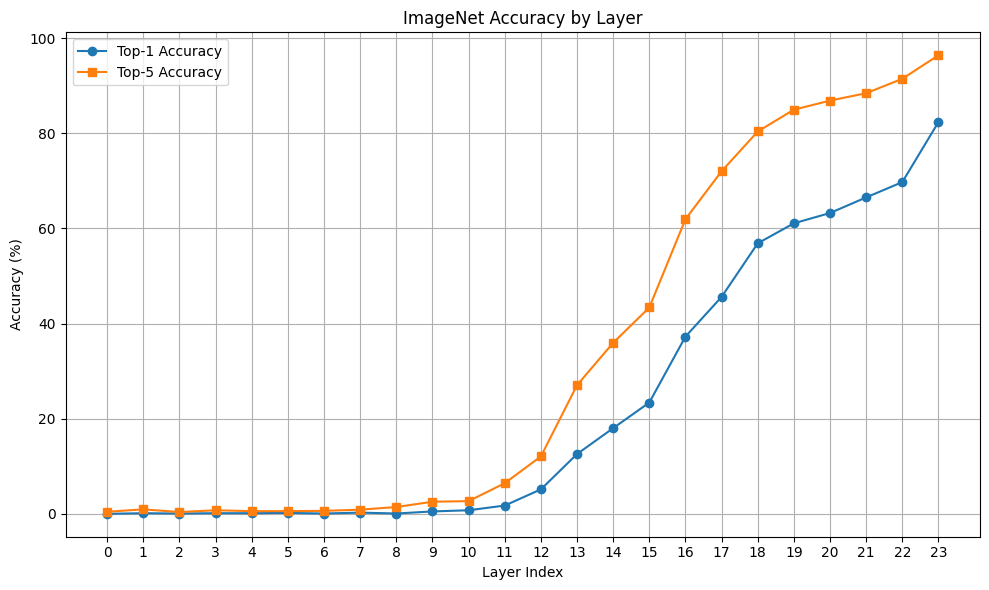

In [21]:
plot_accuracy_by_layer(total_top_acc_resid, title=model_name)

In [14]:
ssv2_path = /network/scratch/s/sonia.joseph/datasets/ssv2/somethingsomething_v2/unzipped/20bn-something-something-v2

SyntaxError: invalid decimal literal (1587470669.py, line 1)

In [13]:
import os
import json
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pathlib import Path
import glob
import cv2
from decord import VideoReader, cpu


class SSv2Dataset(Dataset):
    """
    Dataloader for the Something-Something-V2 dataset
    """
    def __init__(self, root_dir, annotation_file, transform=None, num_frames=32, mode='train'):
        """
        Args:
            root_dir (string): Directory with all the videos.
            annotation_file (string): Path to the annotation file.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_frames (int): Number of frames to sample from the video.
            mode (string): 'train', 'val', or 'test' mode.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.num_frames = num_frames
        self.mode = mode
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Load label mapping
        self.label_map = self._load_label_map(os.path.join(root_dir, 'labels/category.json'))
        
    def _load_label_map(self, label_file):
        """Load mapping from action IDs to label names."""
        with open(label_file, 'r') as f:
            label_map = json.load(f)
        return label_map
    
    def __len__(self):
        return len(self.annotations)
    
    def _get_video_path(self, video_id):
        """
        Find the video file path based on its ID by searching through the dataset directories.
        """
        # Search in all the dataset parts
        for i in range(14):  # Assuming parts 00-13
            part_dir = self.root_dir / f'20bn-something-something-v2-{i:02d}'
            video_path = part_dir / f'{video_id}.webm'
            if video_path.exists():
                return str(video_path)
        
        raise FileNotFoundError(f"Video ID {video_id} not found in any dataset part.")
    
    def _load_video(self, video_path):
        """
        Load video frames using Decord for efficient video decoding.
        """
        try:
            # Load video with Decord
            vr = VideoReader(video_path, ctx=cpu(0))
            
            # Calculate frame indices to sample
            total_frames = len(vr)
            if total_frames <= self.num_frames:
                indices = np.arange(total_frames)
                # If video is too short, repeat the last frame
                if total_frames < self.num_frames:
                    indices = np.pad(indices, (0, self.num_frames - total_frames), 'edge')
            else:
                # Uniformly sample frames
                indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            
            # Load the sampled frames
            frames = vr.get_batch(indices).asnumpy()
            # Convert from (T, H, W, C) to (T, C, H, W) format
            frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
            
            return frames
            
        except Exception as e:
            print(f"Error loading video {video_path}: {str(e)}")
            # Return a dummy tensor in case of error
            return torch.zeros((self.num_frames, 3, 224, 224))
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get annotation for the video
        annotation = self.annotations[idx]
        video_id = annotation['id']
        label_id = annotation['label_id'] if 'label_id' in annotation else -1
        
        # Get video path
        video_path = self._get_video_path(video_id)
        
        # Load video frames
        frames = self._load_video(video_path)
        
        # Apply transformations
        if self.transform:
            # Apply the same transform to all frames
            transformed_frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            transformed_frames = frames
        
        sample = {
            'frames': transformed_frames,
            'label': label_id,
            'video_id': video_id
        }
        
        return sample


def get_transforms(mode='train'):
    """
    Get video transforms for training or validation.
    """
    if mode == 'train':
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    return transform


def create_ssv2_dataloader(root_dir, annotation_file, batch_size=16, num_workers=4, num_frames=32, mode='train'):
    """
    Create a DataLoader for the SSv2 dataset.
    
    Args:
        root_dir (string): Directory with all the videos.
        annotation_file (string): Path to the annotation file.
        batch_size (int): Batch size for the dataloader.
        num_workers (int): Number of worker processes for data loading.
        num_frames (int): Number of frames to sample from each video.
        mode (string): 'train', 'val', or 'test' mode.
        
    Returns:
        DataLoader: PyTorch DataLoader for the SSv2 dataset.
    """
    transform = get_transforms(mode)
    
    dataset = SSv2Dataset(
        root_dir=root_dir,
        annotation_file=annotation_file,
        transform=transform,
        num_frames=num_frames,
        mode=mode
    )
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'train'),
        num_workers=num_workers,
        pin_memory=True,
        drop_last=(mode == 'train')
    )
    
    return dataloader


# Example usage
if __name__ == '__main__':
    # Paths
    root_dir = '/path/to/ssv2_dataset'
    train_annotation = '/path/to/annotations/train.json'
    val_annotation = '/path/to/annotations/validation.json'
    
    # Create dataloaders
    train_loader = create_ssv2_dataloader(
        root_dir=root_dir,
        annotation_file=train_annotation,
        batch_size=16,
        num_workers=4,
        num_frames=32,
        mode='train'
    )
    
    val_loader = create_ssv2_dataloader(
        root_dir=root_dir,
        annotation_file=val_annotation,
        batch_size=16,
        num_workers=4,
        num_frames=32,
        mode='val'
    )
    
    # Test the dataloader
    for batch in train_loader:
        frames = batch['frames']
        labels = batch['label']
        video_ids = batch['video_id']
        
        print(f"Batch shape: {frames.shape}")  # Should be [B, T, C, H, W]
        print(f"Labels: {labels}")
        print(f"Video IDs: {video_ids}")
        break

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/annotations/train.json'

In [ ]:
root_dir = '/network/scratch/s/sonia.joseph/datasets/ssv2/somethingsomething_v2/unzipped'
train_annotation = '/path/to/annotations/train.json'
val_annotation = '/path/to/annotations/validation.json'

# Create dataloaders
train_loader = create_ssv2_dataloader(
    root_dir=root_dir,
    annotation_file=train_annotation,
    batch_size=16,
    num_workers=4,
    num_frames=32,
    mode='train'
)

val_loader = create_ssv2_dataloader(
    root_dir=root_dir,
    annotation_file=val_annotation,
    batch_size=16,
    num_workers=4,
    num_frames=32,
    mode='val'
)

# Test the dataloader
for batch in train_loader:
    frames = batch['frames']
    labels = batch['label']
    video_ids = batch['video_id']
    
    print(f"Batch shape: {frames.shape}")  # Should be [B, T, C, H, W]
    print(f"Labels: {labels}")
    print(f"Video IDs: {video_ids}")
    break